## Import & definitions

In [1]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint
from scipy.stats import uniform
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import xgboost as xgb
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.9 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_df_prob_comb_2 = os.path.join(path_data, 'df_prob_comb_2.csv')
path_df_prob_comb_1b = os.path.join(path_data, 'df_prob_comb_1b.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
path_pca = os.path.join(path_data,"pca_model.pkl")
path_hash_pca = os.path.join(path_data, 'pca_hash.txt')

'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

## Load 

In [2]:
# LOAD
df_prob_comb_high_event = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event.pkl'))
global_event_by_day = pd.read_pickle(os.path.join(path_data, 'global_event_by_day.pkl'))
df_combined_condition = pd.read_pickle(os.path.join(path_data, 'df_combined_condition.pkl'))
df_prob_comb_high_event_test = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event_test.pkl'))
global_event_by_day_test = pd.read_pickle(os.path.join(path_data, 'global_event_by_day_test.pkl'))
df_combined_condition_test = pd.read_pickle(os.path.join(path_data, 'df_combined_condition_test.pkl'))

df_targets = pd.read_pickle(os.path.join(path_data, "df_targets.pkl"))
df_targets_test = pd.read_pickle(os.path.join(path_data, "df_targets_test.pkl"))

with open(os.path.join(path_data, "list_df.pkl"), "rb") as f:
    list_df = pickle.load(f)

with open(os.path.join(path_data, "list_df_test.pkl"), "rb") as f:
    list_df_test = pickle.load(f)

In [3]:
# X train : df_combined_condition train
# X test: df_combined_condition_test

# Y train : high trade or not
y_comb = (list_df[0]["target_cat"] == "high")
# Y test 
y_comb_test = df_targets_test["target_cat"] == "high"

## Functions

In [4]:
# --- Define the new, simplified custom metric ---

def fun_nb_trade_fixed_window(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    
    if y_pred.sum() == 0:
        return 0.0
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    # XGBoost custom metrics must return a list of (name, value) tuples
    return precision_score(y_true, y_pred) + 10*float(total_trades)


In [5]:
def fun_trade(total_trades, winrate, risk=250, R=1.23 ):
    return total_trades * risk * (winrate * (1 + R) - 1)

def fun_arr_trade(arr_trade, arr_winrate, risk=250, R=1.23):
    return arr_trade * risk * (arr_winrate * (1 + R) - 1)

def fun_trades_gain(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    risk = 250
    R = 1.23
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    if y_pred.sum() == 0:
        return 0.0
    
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    winrate = precision_score(y_true, y_pred)
    #total_gain = total_trades * risk * (winrate * (1 + R) - 1)
    total_gain = fun_trade(total_trades, winrate, risk, R )
    # XGBoost custom metrics must return a list of (name, value) tuples
    return total_gain #precision_score(y_true, y_pred) + 10*float(total_trades)


In [6]:
def fun_plot_trades_gain(arr_eval, arr_eval_train, title_str="XBGBoost model performance : total gain"):
    fig = make_subplots(
        rows=2, 
        cols=1, 
        shared_xaxes=True, 
        vertical_spacing=0.03
    )

    fig.add_trace(
        go.Scatter(y=arr_eval["fun_trades_gain"], name="total_gain test"),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(y=arr_eval_train["fun_trades_gain"], name="total_gain train"),
        row=1,
        col=1,
    )
    fig.update_layout(
        height=600,
        template="plotly_white",
        title=title_str,
        hovermode='x unified'
    )
    fig.update_xaxes(
        showspikes=True, 
        spikemode='across', 
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot'
    )

    # Optional: Add y-axis spikes for more context
    fig.update_yaxes(showspikes=True, spikedash='dot')

    fig.show()

In [7]:
def fun_decoded_nb_trade_fixed_window(arr_in):
    # arr_in = np.array(precision_score(y_true, y_pred) + 10*float(total_trades))
    return np.int64(arr_in/10), arr_in%10

def fun_winrate(nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (nb_trade * risk)+1) /(1 + R)

def fun_arr_winrate(arr_nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (arr_nb_trade * risk)+1) /(1 + R)


In [8]:
r_period_test = 1/ (y_comb_test.shape[0]/(30*288))
r_period_train = 1/ (y_comb.shape[0]/(30*288))

In [9]:
# from CV : objective="binary:hinge", scoring="precision", min_resources=500,
# Best Score (Accuracy): 0.3451
#   colsample_bytree: 0.4145
#   learning_rate: 0.5959
#   max_depth: 2
#   reg_alpha: 0.0718
#   reg_lambda: 0.6826
#   subsample: 0.4177
best_params_= {}
best_params_["colsample_bytree"] = 0.4145
best_params_["learning_rate"] = 0.5959
best_params_["max_depth"] = 2
best_params_["reg_alpha"] = 0.0718
best_params_["reg_lambda"] = 0.6826
best_params_["subsample"] = 0.4177


In [10]:
y_comb_test.shape[0]

29720

In [11]:
67047/288

232.80208333333334

In [12]:
tscv = TimeSeriesSplit(n_splits=3)
for i, (train_index, test_index) in enumerate(tscv.split(df_combined_condition.head(29798))):
    print(f"Fold {i}:")
    print(f"  Train: shape={train_index.shape[0]}")
    print(f"  Test:  shape={test_index.shape[0]}")

Fold 0:
  Train: shape=7451
  Test:  shape=7449
Fold 1:
  Train: shape=14900
  Test:  shape=7449
Fold 2:
  Train: shape=22349
  Test:  shape=7449


In [13]:
tscv = TimeSeriesSplit(n_splits=3, test_size=int(8640))
for i, (train_index, test_index) in enumerate(tscv.split(df_combined_condition.head(29798))):
    print(f"Fold {i}:")
    print(f"  Train: shape={train_index.shape[0]}")
    print(f"  Test:  shape={test_index.shape[0]}")

Fold 0:
  Train: shape=3878
  Test:  shape=8640
Fold 1:
  Train: shape=12518
  Test:  shape=8640
Fold 2:
  Train: shape=21158
  Test:  shape=8640


In [14]:
21158/288

73.46527777777777

In [15]:
8640/288

30.0

In [16]:
tscv = TimeSeriesSplit(n_splits=3)
for i, (train_index, test_index) in enumerate(tscv.split(df_combined_condition)):
    print(f"Fold {i}:")
    print(f"  Train: shape={train_index.shape[0]}")
    print(f"  Test:  shape={test_index.shape[0]}")

Fold 0:
  Train: shape=67047
  Test:  shape=67047
Fold 1:
  Train: shape=134094
  Test:  shape=67047
Fold 2:
  Train: shape=201141
  Test:  shape=67047


In [17]:
67047/(288*30)

7.7600694444444445

In [18]:
tscv = TimeSeriesSplit(n_splits=5)
for i, (train_index, test_index) in enumerate(tscv.split(df_combined_condition)):
    print(f"Fold {i}:")
    print(f"  Train: shape={train_index.shape[0]}")
    print(f"  Test:  shape={test_index.shape[0]}")

Fold 0:
  Train: shape=44698
  Test:  shape=44698
Fold 1:
  Train: shape=89396
  Test:  shape=44698
Fold 2:
  Train: shape=134094
  Test:  shape=44698
Fold 3:
  Train: shape=178792
  Test:  shape=44698
Fold 4:
  Train: shape=223490
  Test:  shape=44698


In [19]:
288*30

8640

In [20]:
tscv = TimeSeriesSplit(n_splits=3, test_size=y_comb_test.shape[0])
for i, (train_index, test_index) in enumerate(tscv.split(df_combined_condition)):
    print(f"Fold {i}:")
    print(f"  Train: shape={train_index.shape[0]}")
    print(f"  Test:  shape={test_index.shape[0]}")

Fold 0:
  Train: shape=179028
  Test:  shape=29720
Fold 1:
  Train: shape=208748
  Test:  shape=29720
Fold 2:
  Train: shape=238468
  Test:  shape=29720


## XGBoost

### Search n estimators to converge

Model loaded.
Accuracy on training data: 0.757632705415604
Accuracy on test data: 0.7125504710632571
For Model XGBoost: 
precision TRAIN: 0.563
% possible trades : 2.45
nb trade per day : 7.04
precision TEST: 0.308
% possible trades : 2.03
nb trade per day : 5.85


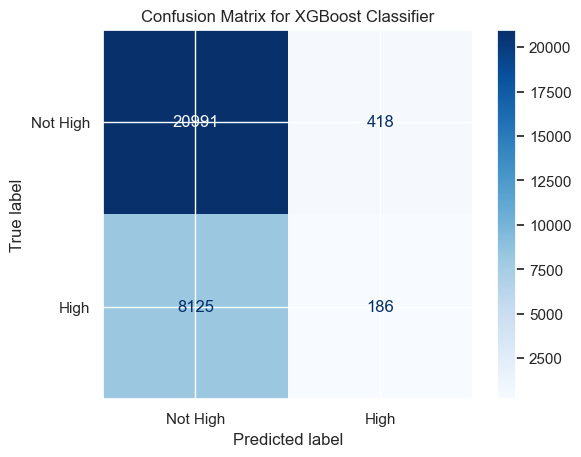

In [21]:
mode_redo_0 = False
if mode_redo_0:
    # n 100 : 14.875
    xgb_mdl = xgb.XGBClassifier(
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=best_params_["max_depth"],
        learning_rate=best_params_["learning_rate"],
        subsample=best_params_["subsample"],
        colsample_bytree=best_params_["colsample_bytree"],
        reg_alpha=best_params_["reg_alpha"],
        reg_lambda=best_params_["reg_lambda"],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=15000,#400+59+1,
    )
    xgb_mdl.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=0,
    )
    print("Model trained.")
    # save xgb_mdl
    with open(os.path.join(path_data,'xgb_mdl_00.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl, f)
else:
    # load  xgb_mdl
    xgb_mdl = pickle.load(open(os.path.join(path_data,'xgb_mdl_00.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [22]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train   gain_train  trades_test  \
0          0.000000         0.000000    -0.000000     0.000000   
1          0.000000         0.000000    -0.000000     0.000000   
2          0.000000         0.000000    -0.000000     0.000000   
3          0.000000         0.000000    -0.000000     0.000000   
4          0.515459         0.545455    27.881793     0.000000   
...             ...              ...          ...          ...   
14995     75.063761         0.603312  6481.488556    59.014805   
14996     64.303548         0.624079  6296.863392    50.874832   
14997     85.340731         0.582915  6398.430917    71.515478   
14998     71.101168         0.608267  6335.743477    55.235532   
14999     92.975972         0.563043  5940.836643    81.981157   

       precision_test    gain_test  run_index  
0            0.000000    -0.000000          0  
1            0.000000    -0.000000          1  
2            0.000000    -0.000000          2  
3            0.000000    -0.000000          3  
4            0.000000    -0.000000          4  
...               ...          ...        ...  
14995        0.320896 -4195.980952      14995  
14996        0.325714 -3480.573380      14996  
14997        0.318458 -5181.987563      14997  
14998        0.321053 -3922.438184      14998  
14999        0.307947 -6420.727157      14999  

[15000 rows x 7 columns]

In [23]:
df[df["gain_test"] == df["gain_test"].max()]

trades_train  precision_train  gain_train  trades_test  precision_test  \
63     15.818157         0.367604 -712.778353    22.094213        0.512048   

     gain_test  run_index  
63  783.610137         63

In [24]:
df.sort_values(by=['gain_test'], ascending=False)

trades_train  precision_train   gain_train  trades_test  \
63        15.818157         0.367604  -712.778353    22.094213   
80        11.919996         0.384937  -421.939533    19.768506   
471       20.940534         0.496933   566.235135    15.407806   
1588      33.601503         0.535254  1626.450700    20.640646   
1590      34.793503         0.526007  1504.780822    23.838493   
...             ...              ...          ...          ...   
14563     93.813593         0.562904  5987.087844    93.318977   
6672      90.205378         0.497780  2481.761940    94.772544   
14940    102.544185         0.535525  4979.052150    96.516824   
12118     92.331648         0.545069  4974.456864    95.063257   
12513     95.875431         0.534571  4604.257686   100.877524   

       precision_test    gain_test  run_index  
63           0.512048   783.610137         63  
80           0.507246   648.202296         80  
471          0.517647   594.559545        471  
1588         0.500000   593.418573       1588  
1590         0.490323   556.749723       1590  
...               ...          ...        ...  
14563        0.294618 -8002.145681      14563  
6672         0.296296 -8038.131402       6672  
14940        0.295958 -8204.259618      14940  
12118        0.292328 -8273.083382      12118  
12513        0.300874 -8298.461996      12513  

[15000 rows x 7 columns]

In [25]:
def fun_arr_winrate(arr_nb_trade, gain, risk, R):
    """Mock function to simulate win rate calculation."""
    # This is a placeholder to make the example runnable.
    # The formula is derived from a common trading gain formula.
    return (gain / arr_nb_trade + risk) / (risk * (1 + R))

# --- Updated plotting function ---

def fun_plot_pre_trade(df, gain_period_min=333, gain_period_bingo=1000):

    arr_nb_trade_winrate_train = np.linspace(max(1, min(df["trades_train"])), max(df["trades_train"]), 100)
    arr_winrate_min_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_min, risk=250, R=1.23)
    arr_winrate_bingo_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_bingo, risk=250, R=1.23)

    # --- Create the Plot with opacity for the test data ---
    fig = px.scatter(
        df,
        x='trades_test',
        y='precision_test',
        title="Evaluation Precision vs. Number of Trades",
        color_discrete_sequence=["#3CB620"], # Green for test data
        opacity=0.6,  # Added opacity for the main scatter plot
    )
    # Customize the hover template
    fig.update_traces(
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "Gain Train: %{customdata[1]:.2f}<br>" +
                "Trades Train: %{customdata[3]:.2f}<br>" +
                "Winrate Train: %{customdata[4]:.4f}<br>" +
                "<b>Gain Test: %{customdata[2]:.2f}</b><br>" +
                "Trades Test: %{x:.2f}<br>" +
                "Winrate Test: %{y:.4f}<br>" + # Corrected from Winrate Train
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_train", "precision_train"]],
            name="test" # Assign a name for the legend
    )

    # add precision = f(nb_trade) to have a gain = 333/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_min_train,
        mode='lines',
        line=dict(color='red', width=2),
        line_dash="dash",
        name="333$/mth Precision",
        hovertemplate=f"Gain: {gain_period_min:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add precision = f(nb_trade) to have a gain = 1000/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_bingo_train,
        mode='lines',
        line=dict(color='blue', width=2),
        line_dash="dash",
        name="1000$/mth Precision",
        hovertemplate=f"Gain: {gain_period_bingo:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add train data with opacity
    fig.add_trace(
        go.Scatter(
            x=df["trades_train"],
            y=df["precision_train"],
            name="train",
            mode="markers",
            # Added marker dict to set color and opacity for the train data
            marker=dict(
                color="#FF7F0E", # Orange for train data
                opacity=0.6
            ),
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "<b>Gain Train: %{customdata[1]:.2f}</b><br>" +
                "Trades Train: %{x:.2f}<br>" +
                "Winrate Train: %{y:.4f}<br>" +
                "Gain Test: %{customdata[2]:.2f}<br>" +
                "Trades Test: %{customdata[3]:.2f}<br>" +
                "Winrate Test: %{customdata[4]:.4f}<br>" +
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_test", "precision_test"]],
        )
    )

    fig.update_layout(
        xaxis_title="Number of Trades / mth",
        yaxis_title="Precision",
        font=dict(family="Arial, sans-serif", size=14),
        height=600,
        legend_title_text='Data Type' # Add a title to the legend
    )

    fig.show()

fun_plot_pre_trade(df)


In [26]:
def fun_plot_xgb_rounds(df, gain_period_min=333, gain_period_bingo=1000):
    """
    Plots XGBoost model performance with semi-transparent markers.
    """
    layout = dict(
        hoversubplots="axis",
        title=dict(text="XBGBoost model performance"),
        hovermode="x",
        grid=dict(rows=3, columns=1),
        height=600,
        xaxis_title="XGB Rounds",
        yaxis=dict(
            title="Trades"
        ),
        yaxis2=dict(
            title="Precision"
        ),
        yaxis3=dict(
            title="Gain"
        )
    )

    # Define marker styles for train and test to reduce repetition
    # The 'opacity' property (from 0 to 1) controls the alpha effect.
    train_marker = dict(color="blue", opacity=0.5)
    test_marker = dict(color="red", opacity=0.5)

    data = [
        go.Scatter(x=df["run_index"], y=df["trades_train"], xaxis="x", yaxis="y", name="trades train", mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["trades_test"], xaxis="x", yaxis="y", name="trades test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["precision_train"], xaxis="x", yaxis="y2", name="pre train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["precision_test"], xaxis="x", yaxis="y2", name="pre test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["gain_train"], xaxis="x", yaxis="y3", name="gain train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["gain_test"], xaxis="x", yaxis="y3", name="gain test",  mode="markers", marker=test_marker),
    ]

    fig = go.Figure(data=data, layout=layout)

    fig.add_hline(
        y=gain_period_min,
        xref="x",
        yref="y3",
        line_dash="dot",
        line=dict(color='red', width=2),
        annotation_text=f"Gain: {gain_period_min:.2f}$/mth",
        annotation_position="bottom right",
        annotation_font_color="red",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.add_hline(
        y=gain_period_bingo,
        xref="x",
        yref="y3",
        line_dash="dot",
        annotation_text=f"Gain: {gain_period_bingo:.2f}$/mth",
        annotation_position="top right",
        annotation_font_color="blue",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.update_xaxes(
        showspikes=True,
        spikemode='across',
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot',
    )
    fig.show()

fun_plot_xgb_rounds(df)


In [27]:
fun_plot_xgb_rounds(df[(df["gain_test"] > -10000) & (df["run_index"] < 500)])

### CV scoring average_precision

In [28]:
mode_redo = False

In [29]:
if mode_redo:
    # --- 3. Define the Base Model ---
    # Note: 'n_estimators' is controlled by the search, so we don't set it here.
    # 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
    xgb_mdl = xgb.XGBClassifier(
        objective="binary:hinge",
        random_state=42,
        #use_label_encoder=False, # Recommended to avoid a future warning
        #eval_metric=fun_nb_trade_fixed_window, # A common metric for binary classification
        n_estimators=1000,
    )

    # --- 4. Define the Hyperparameter Search Space ---
    param_dist = {
        'max_depth': randint(1, 4),             # Search depths from 2 to 4
        'learning_rate': uniform(0.01, 1),   # Search from 0.05 up to 0.6
        'subsample': uniform(0.2, 0.9),         # Search between 0.4 and 0.9
        'colsample_bytree': uniform(0.1, 0.7),  # Search between 0.1 and 0.6
        'reg_alpha': uniform(0.0, 1),         # Search L1 regularization
        'reg_lambda': uniform(0.0, 1),        # Search L2 regularization
        #'scale_pos_weight': uniform(1, 3),  # ajuster si classes déséquilibrées
    }

    tscv = TimeSeriesSplit(n_splits=5)

    # --- 5. Set up and Run HalvingRandomSearchCV ---
    halving_search = HalvingRandomSearchCV(
        n_jobs=-1,                # Use all available CPU cores
        random_state=42,
        verbose=1,                # Set to 1 or 2 to see the progress
        cv=tscv,
        factor=2,  # Keep the top 1/3 of candidates in each iteration
        estimator=xgb_mdl,
        param_distributions=param_dist,
        #max_resources=150,        # The maximum n_estimators to use for the final model
        min_resources=250,         # The initial n_samples to start with
        scoring='average_precision',       # Metric for evaluation, since hinge loss gives 0/1
    )

    print("Starting HalvingRandomSearchCV...")
    # Fit the model to the data
    halving_search.fit(df_combined_condition, y_comb)
    print("\nSearch complete!")

    # --- 6. Display the Results ---
    print("\n--- Cross-Validation Results ---")
    print(f"Best Score (Accuracy): {halving_search.best_score_:.4f}")
    print("\nBest Parameters Found:")
    # Using a loop for cleaner printing
    for param, value in halving_search.best_params_.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    # save halving_search
    with open(os.path.join(path_data,'xgb_halving_search_01.pkl'), 'wb') as f:
        pickle.dump(halving_search, f)
else:
    # load  halving_search
    halving_search = pickle.load(open(os.path.join(path_data,'xgb_halving_search_01.pkl'), 'rb'))

# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model = halving_search.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")
halving_search.best_params_


Best model is now trained and ready to be used for predictions.


{'colsample_bytree': np.float64(0.12178091994215039),
 'learning_rate': np.float64(0.7492947351647732),
 'max_depth': 2,
 'reg_alpha': np.float64(0.325104015431699),
 'reg_lambda': np.float64(0.6863271966860974),
 'subsample': np.float64(0.2626770333461652)}

In [30]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.12178091994215039), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.7492947351647732), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

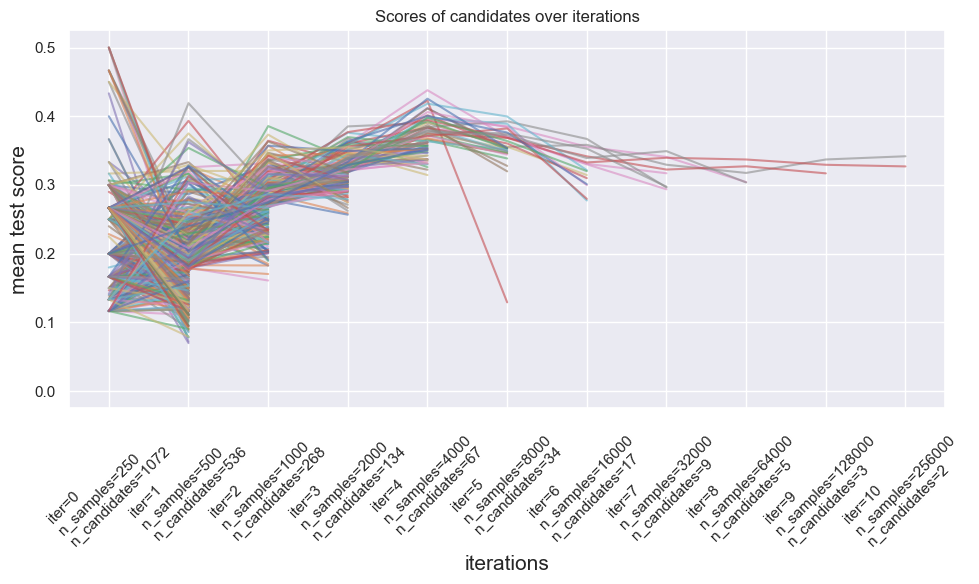

In [31]:
# --- Cross-Validation Results ---

# Best Parameters Found:
# {'colsample_bytree': np.float64(0.3816843815095182),
#  'learning_rate': np.float64(0.8945868882296137),
#  'max_depth': 3,
#  'reg_alpha': np.float64(0.29507234926430936),
#  'reg_lambda': np.float64(0.2988571352590308),
#  'subsample': np.float64(0.2963514606987675)}


results = pd.DataFrame(halving_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search.n_resources_[i]}\nn_candidates={halving_search.n_candidates_[i]}"
    for i in range(halving_search.n_iterations_)
]

ax.set_xticks(range(halving_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

Model trained.
Accuracy on training data: 0.7535348337733232
Accuracy on test data: 0.7184387617765814
For Model XGBoost: 
precision TRAIN: 0.451
% possible trades : 1.04
nb trade per day : 3.00
precision TEST: 0.380
% possible trades : 0.80
nb trade per day : 2.30


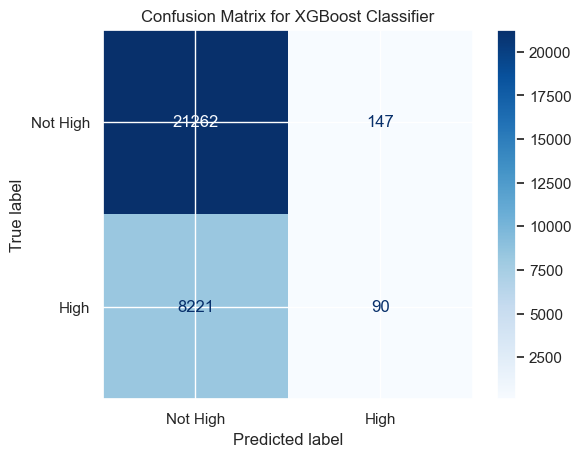

In [32]:
print("Model trained.")
print("Accuracy on training data:", best_model.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model.predict(df_combined_condition)
arr_xgb_pred = best_model.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [33]:
halving_search.best_params_

{'colsample_bytree': np.float64(0.12178091994215039),
 'learning_rate': np.float64(0.7492947351647732),
 'max_depth': 2,
 'reg_alpha': np.float64(0.325104015431699),
 'reg_lambda': np.float64(0.6863271966860974),
 'subsample': np.float64(0.2626770333461652)}

In [34]:
mode_redo = False

Model loaded.
Accuracy on training data: 0.7610258475397855
Accuracy on test data: 0.7068977119784656
For Model XGBoost: 
precision TRAIN: 0.576
% possible trades : 4.26
nb trade per day : 12.27
precision TEST: 0.313
% possible trades : 3.59
nb trade per day : 10.35


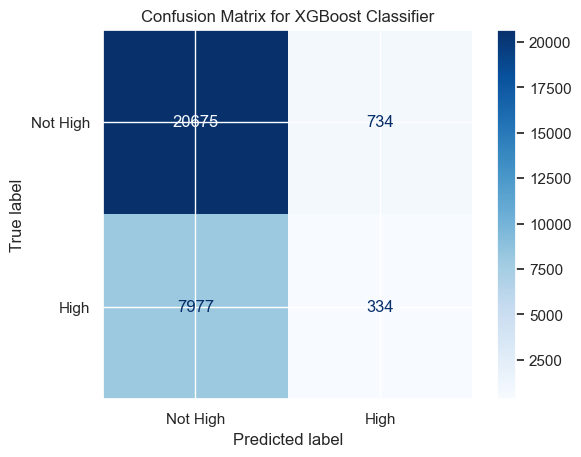

In [35]:
#   colsample_bytree: 0.4829
#   learning_rate: 0.8398
#   max_depth: 3
#   reg_alpha: 0.7804
#   reg_lambda: 0.4580
#   scale_pos_weight: 2.1940
#   subsample: 0.4726
if mode_redo:
    # n 100 : 14.875
    xgb_mdl = xgb.XGBClassifier(
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=halving_search.best_params_["max_depth"],
        learning_rate=halving_search.best_params_["learning_rate"],
        subsample=halving_search.best_params_["subsample"],
        colsample_bytree=halving_search.best_params_["colsample_bytree"],
        reg_alpha=halving_search.best_params_["reg_alpha"],
        reg_lambda=halving_search.best_params_["reg_lambda"],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=10000,#400+59+1,
    )
    xgb_mdl.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=0,
    )
    print("Model trained.")
    # save xgb_mdl
    with open(os.path.join(path_data,'xgb_mdl_01.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl, f)
else:
    # load  xgb_mdl
    xgb_mdl = pickle.load(open(os.path.join(path_data,'xgb_mdl_01.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [36]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train    gain_train  trades_test  \
0         4.155891         0.412646    -82.909416     0.000000   
1         0.000000         0.000000     -0.000000     0.000000   
2         0.837621         0.565217     54.536252     0.000000   
3        10.631348         0.432398    -95.024212     7.849260   
4         7.989619         0.396199   -232.650182     2.034993   
...            ...              ...           ...          ...   
9995    123.839098         0.622815  12039.558155   104.947510   
9996    169.843841         0.539023   8578.017958   161.927322   
9997    135.018122         0.600675  11459.840284   117.448183   
9998    114.560830         0.636928  12038.895233    95.644684   
9999    151.802765         0.576018  10797.736003   132.565276   

      precision_test     gain_test  run_index  
0           0.000000     -0.000000          0  
1           0.000000     -0.000000          1  
2           0.000000     -0.000000          2  
3           0.166667  -1232.986428          3  
4           0.421053    -31.060006          4  
...              ...           ...        ...  
9995        0.308564  -8183.341920       9995  
9996        0.332114 -10500.411159       9996  
9997        0.311185  -8986.472852       9997  
9998        0.312588  -7243.381360       9998  
9999        0.312734 -10028.668512       9999  

[10000 rows x 7 columns]

In [37]:
#fun_plot_pre_trade(df)

In [38]:
#fun_plot_xgb_rounds(df)

### CV scoring precision

In [39]:
mode_redo = True

In [40]:
randint(1, 6).rvs(10)

array([5, 3, 4, 4, 4, 2, 3, 2, 2, 4])

In [41]:
uniform(0.4, 1-0.4).rvs(10)

array([0.91038876, 0.45103748, 0.45000191, 0.59010073, 0.86079098,
       0.7151331 , 0.76484668, 0.43152343, 0.88929508, 0.58838194])

In [42]:
int(y_comb.shape[0]/3/3)

29798

In [43]:
29798*3*3

268182

In [44]:
y_comb.shape[0]

268188

In [45]:
(y_comb.shape[0]/3/3)/288

103.4675925925926

In [46]:
4**6

4096

In [47]:
        # resource= "n_estimators",
        # factor=3,  # Keep the top 1/3 of candidates in each iteration
        # n_candidates=2000, # 
        # min_resources=50,
        # aggressive_elimination=False,
        # max_resources=500, 
# Starting HalvingRandomSearchCV...
# n_iterations: 3
# n_required_iterations: 7
# n_possible_iterations: 3
# min_resources_: 50
# max_resources_: 500
# aggressive_elimination: False
# factor: 3
# ----------
# iter: 0
# n_candidates: 2000
# n_resources: 50
# Fitting 3 folds for each of 2000 candidates, totalling 6000 fits

In [48]:
make_scorer(precision_score, zero_division=0)

make_scorer(precision_score, response_method='predict', zero_division=0)

In [49]:
# 11 iterations / 173min !  8000 resources sur trop de iteration puis division par 2 jusqu'a itera 6 ? 
# 2000 /2 , /2 /2 ... 11 fois
if mode_redo:
    # --- 3. Define the Base Model ---
    # Note: 'n_estimators' is controlled by the search, so we don't set it here.
    # 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
    xgb_mdl = xgb.XGBClassifier(
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        #eval_metric=fun_nb_trade_fixed_window, # A common metric for binary classification
        #n_estimators=100,
    )

    # --- 4. Define the Hyperparameter Search Space ---
    param_dist = {
        'max_depth': randint(1, 6),             # Search depths from 1 to 6
        'learning_rate': uniform(0.05, 1-0.05),   # Search from 0.05 up to 0.6
        'subsample': uniform(0.5, 0.85-0.5),         # Search between 0.4 and 0.9
        'colsample_bytree': uniform(0.5, 0.85-0.5),  # Search between 0.1 and 0.6
        'reg_alpha': uniform(0.0, 20),         # Search L1 regularization
        'reg_lambda': uniform(0.1, 40),        # Search L2 regularization
        #'scale_pos_weight': uniform(1, 3),  # ajuster si classes déséquilibrées
    }

    tscv = TimeSeriesSplit(n_splits=3, test_size=y_comb_test.shape[0])

    # --- 5. Set up and Run HalvingRandomSearchCV ---
    halving_search_2 = HalvingRandomSearchCV(
        n_jobs=-1,                # Use all available CPU cores
        random_state=42,
        verbose=2,                # Set to 1 or 2 to see the progress
        cv=tscv,
        estimator=xgb_mdl,
        param_distributions=param_dist,
        resource= "n_estimators",
        factor=3,  # Keep the top 1/3 of candidates in each iteration
        n_candidates=100, # 
        min_resources=50,
        aggressive_elimination=False,
        max_resources=500,        # The maximum n samples to use for the final model
        scoring=make_scorer(precision_score, zero_division=0),       # Metric for evaluation, since hinge loss gives 0/1
    )

    print("Starting HalvingRandomSearchCV...")
    # Fit the model to the data
    halving_search_2.fit(df_combined_condition, y_comb)
    print("\nSearch complete!")

    # --- 6. Display the Results ---
    print("\n--- Cross-Validation Results ---")
    print(f"Best Score (Accuracy): {halving_search_2.best_score_:.4f}")
    print("\nBest Parameters Found:")
    # Using a loop for cleaner printing
    for param, value in halving_search_2.best_params_.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    # save halving_search
    with open(os.path.join(path_data,'xgb_halving_search_02_02.pkl'), 'wb') as f:
        pickle.dump(halving_search_2, f)
else:
    # load  halving_search
    halving_search_2 = pickle.load(open(os.path.join(path_data,'xgb_halving_search_02_02.pkl'), 'rb'))
# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model_2 = halving_search_2.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")

Starting HalvingRandomSearchCV...
n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 50
max_resources_: 500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 50
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.6836647510712832, learning_rate=0.46034776771000996, max_depth=1, n_estimators=50, reg_alpha=10.495493205167783, reg_lambda=16.09443886861022, subsample=0.5163329821247654; total time= 5.0min
[CV] END colsample_bytree=0.839468448256698, learning_rate=0.8408205087604007, max_depth=2, n_estimators=50, reg_alpha=3.6364993441420124, reg_lambda=7.436180394137352, subsample=0.6064847850358381; total time= 5.1min
[CV] END colsample_bytree=0.6310890415965769, learning_rate=0.9531785910894204, max_depth=3, n_estimators=50, reg_alpha=15.593820005455385, reg_lambda=23.97400631785948, subsample=0.6560414634987569; total time= 5.2min
[CV] END colsample_bytree=0.534991220536301, lea

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV] END colsample_bytree=0.6248636643427562, learning_rate=0.3168877842030117, max_depth=4, n_estimators=50, reg_alpha=5.519983640450867, reg_lambda=11.950940228163295, subsample=0.5578434286720508; total time= 5.9min
[CV] END colsample_bytree=0.5054727423594179, learning_rate=0.4522314066710511, max_depth=1, n_estimators=50, reg_alpha=3.974313630683448, reg_lambda=0.32088468494409594, subsample=0.7854114999591919; total time= 5.1min
[CV] END colsample_bytree=0.747400070346666, learning_rate=0.742556809638938, max_depth=1, n_estimators=50, reg_alpha=12.119199495620228, reg_lambda=37.15203514053396, subsample=0.7278769589256806; total time= 4.5min
[CV] END colsample_bytree=0.747400070346666, learning_rate=0.742556809638938, max_depth=1, n_estimators=50, reg_alpha=12.119199495620228, reg_lambda=37.15203514053396, subsample=0.7278769589256806; total time= 5.2min
[CV] END colsample_bytree=0.8202358864403232, learning_rate=0.8575366489003093, max_depth=4, n_estimators=50, reg_alpha=6.61796

In [84]:
results.sort_values(by="mean_test_score", ascending=False).head(60)

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
21      0           50     309.947624     48.335585         4.538964   
77      0           50     317.845345     19.572157         3.423188   
13      0           50     267.078535     30.672521         3.682457   
27      0           50     268.789665     34.069225         3.313958   
133     1          150     293.205432     12.964532         1.456117   
139     2          450    1411.248267    164.646493         3.609187   
56      0           50     279.584721     35.529194         3.449685   
109     1          150     434.666408     66.696829         3.764943   
142     2          450    1283.969036     94.061324         2.941729   
143     2          450    1153.656590     52.794333         2.118668   
119     1          150     412.028327     60.058285         3.027708   
95      0           50     228.717988     28.587488         3.324108   
126     1          150     474.553538     81.958281         3.787380   
11      0           50     309.396818     35.755190         3.895492   
140     2          450    1442.530137    162.263067         3.820086   
35      0           50     326.920338     34.734630         3.865654   
8       0           50     264.318798     24.832305         3.942182   
136     2          450    1546.620387    201.665449         4.098069   
118     1          150     418.406997     60.590493         3.174739   
123     1          150     458.028802     77.407256         4.258626   
9       0           50     293.566517     55.622521         3.564258   
128     1          150     455.672034     83.438813         3.634077   
141     2          450    1412.311624    179.263819         3.528183   
45      0           50     305.212863     47.061524         3.812348   
79      0           50     255.851730     25.739178         3.398285   
41      0           50     283.384417     45.634742         3.846350   
135     2          450    1496.529606    194.562402         3.838425   
92      0           50     232.729598     29.326999         3.198941   
31      0           50     289.541234     41.315635         3.496130   
121     1          150     426.173284     73.468836         4.021699   
144     2          450    1063.759317     25.043466         1.806609   
74      0           50     395.477590     51.840032         5.488029   
107     1          150     438.728872     60.838916         3.421052   
137     2          450    1534.890637    203.033737         4.033749   
105     1          150     426.053159     80.217466         3.446837   
110     1          150     425.037306     65.971954         3.232054   
125     1          150     421.151268     61.322881         3.245342   
103     1          150     488.816870     72.172918         3.318989   
0       0           50     368.263990     46.664099         4.328588   
138     2          450    1459.417871    175.908693         3.566452   
111     1          150     421.013818     60.492643         3.394908   
112     1          150     375.843806     49.203093         3.203366   
7       0           50     328.398966     33.661700         3.679638   
114     1          150     422.106864     65.708855         3.721451   
102     1          150     474.415987     68.368005         3.186780   
116     1          150     408.078315     61.750068         3.618899   
14      0           50     291.558884     49.039135         4.434984   
115     1          150     423.744660     66.878181         3.372154   
108     1          150     422.100730     64.397561         3.176863   
34      0           50     321.610150     47.823740         4.195389   
19      0           50     298.326809     49.270973         3.920723   
106     1          150     412.727551     66.743632         3.121426   
91      0           50     230.569787     28.468922         3.058422   
18      0           50     294.794846     39.397250         4.050527   
85      0           50     235.850917     31.

In [100]:
results["params_str"].values[0]

"{'colsample_bytree': np.float64(0.6310890415965769), 'learning_rate': np.float64(0.9531785910894204), 'max_depth': 3, 'reg_alpha': np.float64(15.593820005455385), 'reg_lambda': np.float64(23.97400631785948), 'subsample': np.float64(0.6560414634987569), 'n_estimators': 50}"

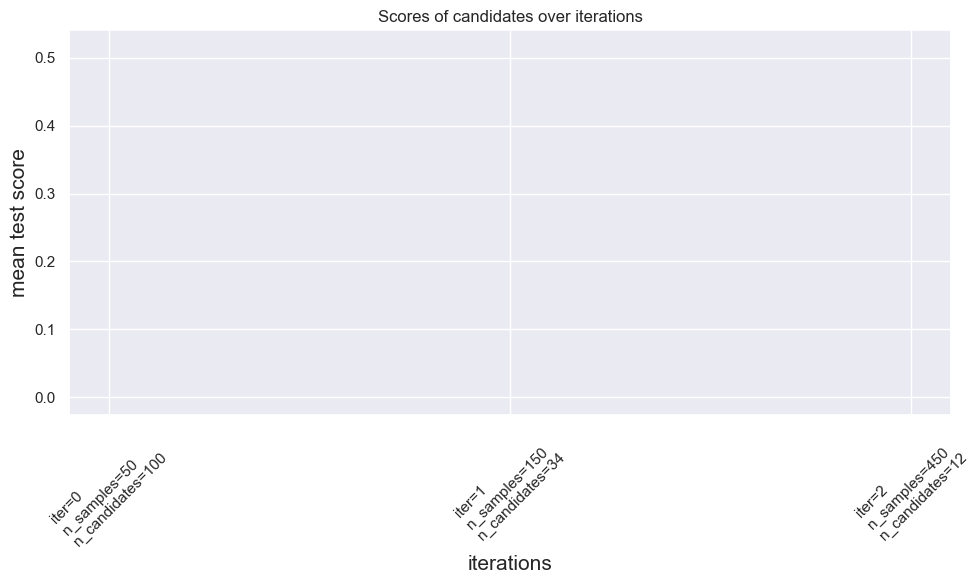

In [105]:
results = pd.DataFrame(halving_search_2.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search_2.n_resources_[i]}\nn_candidates={halving_search_2.n_candidates_[i]}"
    for i in range(halving_search_2.n_iterations_)
]

ax.set_xticks(range(halving_search_2.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

In [109]:
mean_scores

params_str  {'colsample_bytree': np.float64(0.5024332456859167), 'learning_rate': np.float64(0.5352099374486874), 'max_depth': 1, 'reg_alpha': np.float64(9.696599427179663), 'reg_lambda': np.float64(27.797441315610815), 'subsample': np.float64(0.5942943168294825), 'n_estimators': 50}  \
iter                                                                                                                                                                                                                                                                                           
0                                                         0.0                                                                                                                                                                                                                                  
1                                                         NaN                                                                                                                                                                                                                                  
2                                                         NaN                                                                                                                                                                                                                                  

params_str  {'colsample_bytree': np.float64(0.5054727423594179), 'learning_rate': np.float64(0.4522314066710511), 'max_depth': 1, 'reg_alpha': np.float64(3.974313630683448), 'reg_lambda': np.float64(0.32088468494409594), 'subsample': np.float64(0.7854114999591919), 'n_estimators': 50}  \
iter                                                                                                                                                                                                                                                                                            
0                                                         0.0                                                                                                                                                                                                                                   
1                                                         NaN                                                                                                                                                                                                                                   
2                                                         NaN                                                                                                                                                                                                                                   

params_str  {'colsample_bytree': np.float64(0.5085105882510088), 'learning_rate': np.float64(0.6631986811118095), 'max_depth': 1, 'reg_alpha': np.float64(19.89101021594682), 'reg_lambda': np.float64(18.89778055963772), 'subsample': np.float64(0.5978461196288655), 'n_estimators': 50}  \
iter                                                                                                                                                                                                                                                                                          
0                                                    0.188406                                                                                                                                                                                                                                 
1                                                         NaN                                                                                                                                                                                               

In [106]:
results["params_str"].values[0]

"{'colsample_bytree': np.float64(0.6310890415965769), 'learning_rate': np.float64(0.9531785910894204), 'max_depth': 3, 'reg_alpha': np.float64(15.593820005455385), 'reg_lambda': np.float64(23.97400631785948), 'subsample': np.float64(0.6560414634987569), 'n_estimators': 50}"

Model trained.
Accuracy on training data: 0.760030277268185
Accuracy on test data: 0.7157469717362046
For Model XGBoost: 
precision TRAIN: 0.674
% possible trades : 1.58
nb trade per day : 4.54
precision TEST: 0.313
% possible trades : 1.23
nb trade per day : 3.56


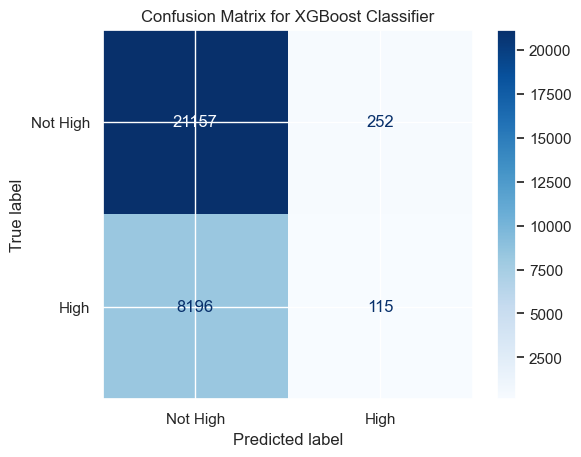

In [107]:
print("Model trained.")
print("Accuracy on training data:", best_model_2.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model_2.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model_2.predict(df_combined_condition)
arr_xgb_pred = best_model_2.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [52]:
results

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0       0           50     368.263990     46.664099         4.328588   
1       0           50     377.441993     47.495413         5.038511   
2       0           50     364.462938     46.212447         4.180432   
3       0           50     355.689977     47.335958         4.287896   
4       0           50     293.356426     50.789435         3.852288   
..    ...          ...            ...           ...              ...   
141     2          450    1412.311624    179.263819         3.528183   
142     2          450    1283.969036     94.061324         2.941729   
143     2          450    1153.656590     52.794333         2.118668   
144     2          450    1063.759317     25.043466         1.806609   
145     2          450     847.759669     15.970559         1.437790   

     std_score_time  param_colsample_bytree  param_learning_rate  \
0          0.486832                0.631089             0.953179   
1          2.429244                0.534991             0.486286   
2          0.535365                0.839468             0.840821   
3          0.470227                0.683665             0.460348   
4          0.371200                0.840814             0.271133   
..              ...                     ...                  ...   
141        0.270340                0.803404             0.846557   
142        0.759373                0.535515             0.680327   
143        0.519231                0.689507             0.710995   
144        0.444418                0.837267             0.860359   
145        0.364122                0.817390             0.308526   

     param_max_depth  param_reg_alpha  ...  split2_test_score  \
0                  3        15.593820  ...           0.369668   
1                  5        12.022300  ...           0.279221   
2                  2         3.636499  ...           0.335950   
3                  1        10.495493  ...           0.000000   
4                  3         7.649240  ...           0.571429   
..               ...              ...  ...                ...   
141                5         4.451528  ...           0.361691   
142                5         5.678419  ...           0.395367   
143                4         3.499099  ...           0.394924   
144                5         7.701955  ...           0.388608   
145                3         8.542156  ...           0.287958   

     mean_test_score  std_test_score rank_test_score  split0_train_score  \
0           0.346693        0.023177              39            0.600277   
1           0.304197        0.065658             101            0.720515   
2           0.318633        0.032785              86            0.531915   
3           0.259259        0.366648             111            0.395349   
4           0.283069        0.233315             106            0.800000   
..               ...             ...             ...                 ...   
141         0.358654        0.002335              23            0.786047   
142         0.370956        0.017397               9            0.826182   
143         0.369258        0.028258              10            0.776524   
144         0.352716        0.026294              31            0.771312   
145         0.335312        0.034006              61            0.777444   

     split1_train_score  split2_train_score  mean_train_score  \
0              0.515363            0.433931          0.516523   
1              0.715543            0.755882          0.730647   
2              0.472941            0.362921          0.455926   
3              0.000000            0.000000          0.131783   
4              0.666667            0.774194          0.746953   
..                  ...                 ...               ...   
141            0.827366            0.658130          0.757181   
142            0.826108            0.778888          0.810393   
143            0.747645            0.725718 

In [53]:
halving_search_2.best_params_

{'colsample_bytree': np.float64(0.6077220339198672),
 'learning_rate': np.float64(0.8255664484524092),
 'max_depth': 4,
 'reg_alpha': np.float64(11.218759430707726),
 'reg_lambda': np.float64(35.1661441063338),
 'subsample': np.float64(0.641219003174339),
 'n_estimators': 450}

In [76]:
halving_search_2.best_params_

{'colsample_bytree': np.float64(0.6077220339198672),
 'learning_rate': np.float64(0.8255664484524092),
 'max_depth': 4,
 'reg_alpha': np.float64(11.218759430707726),
 'reg_lambda': np.float64(35.1661441063338),
 'subsample': np.float64(0.641219003174339),
 'n_estimators': 450}

In [91]:
results.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_colsample_bytree',
       'param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'mean_train_score', 'std_train_score', 'params_str'],
      dtype='object')

In [93]:
results[results["rank_test_score"] == 1].iloc[0]["param_n_estimators"]

np.int64(50)

In [94]:
mode_redo = True

Model trained.
Accuracy on training data: 0.7621370083672647
Accuracy on test data: 0.7166554508748317
For Model XGBoost: 
precision TRAIN: 0.766
% possible trades : 1.43
nb trade per day : 4.11
precision TEST: 0.331
% possible trades : 1.10
nb trade per day : 3.16


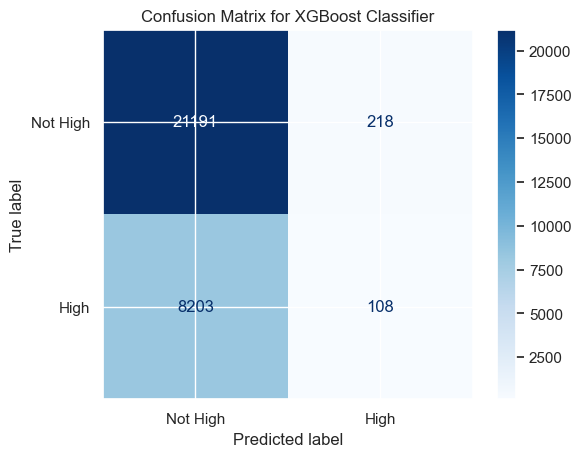

In [96]:
# {'colsample_bytree': np.float64(0.12178091994215039),
#  'learning_rate': np.float64(0.7492947351647732),
#  'max_depth': 2,
#  'reg_alpha': np.float64(0.325104015431699),
#  'reg_lambda': np.float64(0.6863271966860974),
#  'subsample': np.float64(0.2626770333461652)}
if mode_redo:
    # n 100 : 14.875
    xgb_mdl = xgb.XGBClassifier(
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=results[results["rank_test_score"] == 1].iloc[0]["param_max_depth"],
        learning_rate=results[results["rank_test_score"] == 1].iloc[0]["param_learning_rate"],
        subsample=results[results["rank_test_score"] == 1].iloc[0]["param_subsample"],
        colsample_bytree=results[results["rank_test_score"] == 1].iloc[0]["param_colsample_bytree"],
        reg_alpha=results[results["rank_test_score"] == 1].iloc[0]["param_reg_alpha"],
        reg_lambda=results[results["rank_test_score"] == 1].iloc[0]["param_reg_lambda"],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=10000,#400+59+1,
    )
    xgb_mdl.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=0,
    )
    print("Model trained.")
    # save xgb_mdl
    with open(os.path.join(path_data,'xgb_mdl_02_02.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl, f)
else:
    # load  xgb_mdl
    xgb_mdl = pickle.load(open(os.path.join(path_data,'xgb_mdl_02_02.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [97]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train   gain_train  trades_test  precision_test  \
0         2.351783         0.506993    76.782419     0.000000        0.000000   
1         2.351783         0.506993    76.782419     0.000000        0.000000   
2         2.351783         0.506993    76.782419     0.000000        0.000000   
3         2.351783         0.506993    76.782419     0.000000        0.000000   
4         0.000000         0.000000    -0.000000     0.000000        0.000000   
...            ...              ...          ...          ...             ...   
9995     49.870688         0.766865  8853.405424    40.118439        0.337748   
9996     53.124525         0.762356  9297.507390    45.641992        0.337313   
9997     50.160634         0.767367  8918.916917    41.281292        0.340836   
9998     55.766254         0.753644  9488.992191    47.967699        0.355114   
9999     51.868093         0.765735  9175.323580    44.188425        0.331288   

        gain_test  run_index  
0       -0.000000          0  
1       -0.000000          1  
2       -0.000000          2  
3       -0.000000          3  
4       -0.000000          4  
...           ...        ...  
9995 -2475.527922       9995  
9996 -2827.430230       9996  
9997 -2476.214133       9997  
9998 -2495.468910       9998  
9999 -2885.810840       9999  

[10000 rows x 7 columns]

In [98]:
fun_plot_pre_trade(df)

In [99]:
fun_plot_xgb_rounds(df)

### CV scoring fun_trades_gain

In [59]:

fun_score_trades_gain = make_scorer(fun_trades_gain, greater_is_better=True)

In [60]:
mode_redo = False

In [61]:
# {'colsample_bytree': np.float64(0.4633418536357893),
#  'learning_rate': np.float64(0.0776125635922149),
#  'max_depth': 1,
#  'reg_alpha': np.float64(0.06993160570943413),
#  'reg_lambda': np.float64(0.6401682238281661),
#  'subsample': np.float64(0.44403269285016633)}
if mode_redo: 
    # 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
    xgb_mdl = xgb.XGBClassifier(
        objective="binary:hinge",
        random_state=42,
        #use_label_encoder=False, # Recommended to avoid a future warning
        #eval_metric=fun_nb_trade_fixed_window, # A common metric for binary classification
        n_estimators=1000,
    )

    # --- 4. Define the Hyperparameter Search Space ---
    param_dist = {
        'max_depth': randint(1, 4),             # Search depths from 2 to 4
        'learning_rate': uniform(0.01, 1),   # Search from 0.05 up to 0.6
        'subsample': uniform(0.2, 0.9),         # Search between 0.4 and 0.9
        'colsample_bytree': uniform(0.1, 0.7),  # Search between 0.1 and 0.6
        'reg_alpha': uniform(0.0, 1),         # Search L1 regularization
        'reg_lambda': uniform(0.0, 1),        # Search L2 regularization
        #'scale_pos_weight': uniform(1, 3),  # ajuster si classes déséquilibrées
    }

    tscv = TimeSeriesSplit(n_splits=5)

    # --- 5. Set up and Run HalvingRandomSearchCV ---
    halving_search_3 = HalvingRandomSearchCV(
        n_jobs=-1,                # Use all available CPU cores
        random_state=42,
        verbose=1,                # Set to 1 or 2 to see the progress
        cv=tscv,
        factor=2,  # Keep the top 1/3 of candidates in each iteration
        estimator=xgb_mdl,
        param_distributions=param_dist,
        #max_resources=150,        # The maximum n samples to use for the final model
        min_resources=250,#500,         # The initial n_samples to start with
        scoring=fun_score_trades_gain,       # Metric for evaluation, since hinge loss gives 0/1
    )

    print("Starting HalvingRandomSearchCV...")
    # Fit the model to the data
    halving_search_3.fit(df_combined_condition, y_comb)
    print("\nSearch complete!")

    # --- 6. Display the Results ---
    print("\n--- Cross-Validation Results ---")
    print(f"Best Score (Accuracy): {halving_search_3.best_score_:.4f}")
    print("\nBest Parameters Found:")
    # Using a loop for cleaner printing
    for param, value in halving_search_3.best_params_.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    # save halving_search
    with open(os.path.join(path_data,'xgb_halving_search_03.pkl'), 'wb') as f:
        pickle.dump(halving_search_3, f)
else:
    # load  halving_search
    halving_search_3 = pickle.load(open(os.path.join(path_data,'xgb_halving_search_03.pkl'), 'rb'))
# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model_3 = halving_search_3.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")


Best model is now trained and ready to be used for predictions.


In [62]:
halving_search_3.best_params_

{'colsample_bytree': np.float64(0.7443751195717883),
 'learning_rate': np.float64(0.022003027272682545),
 'max_depth': 1,
 'reg_alpha': np.float64(0.6235191951741544),
 'reg_lambda': np.float64(0.06310636911554623),
 'subsample': np.float64(0.4921482516591454)}

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of labels (3).

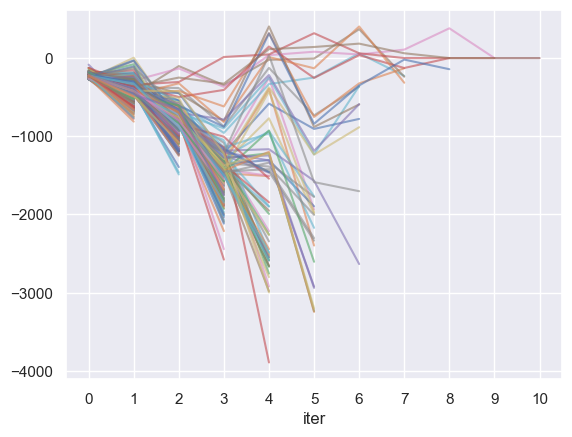

In [63]:
# --- Cross-Validation Results ---
# Best Score (Accuracy): 0.0000

# {'colsample_bytree': np.float64(0.7443751195717883),
#  'learning_rate': np.float64(0.022003027272682545),
#  'max_depth': 1,
#  'reg_alpha': np.float64(0.6235191951741544),
#  'reg_lambda': np.float64(0.06310636911554623),
#  'subsample': np.float64(0.4921482516591454)}

results = pd.DataFrame(halving_search_3.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search_3.n_resources_[i]}\nn_candidates={halving_search_3.n_candidates_[i]}"
    for i in range(halving_search_2.n_iterations_)
]

ax.set_xticks(range(halving_search_3.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

Model trained.
Accuracy on training data: 0.7545490476829687
Accuracy on test data: 0.7203566621803499
For Model XGBoost: 
precision TRAIN: 0.000
% possible trades : 0.00
nb trade per day : 0.00
precision TEST: 0.000
% possible trades : 0.00
nb trade per day : 0.00


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



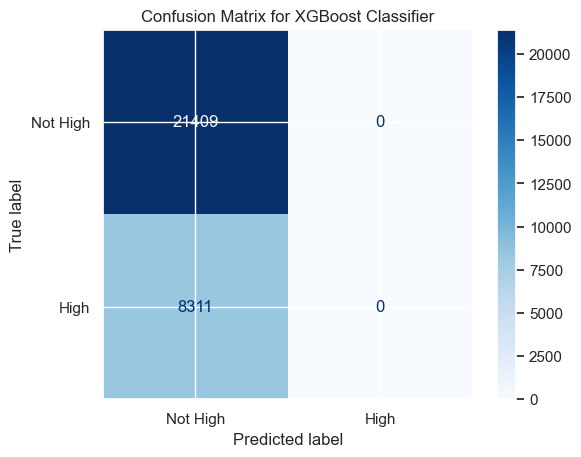

In [ ]:
print("Model trained.")
print("Accuracy on training data:", best_model_3.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model_3.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model_3.predict(df_combined_condition)
arr_xgb_pred = best_model_3.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [ ]:
results

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0        0          250       7.495746      0.463490         0.319316   
1        0          250       7.512894      0.581132         0.319472   
2        0          250       6.635143      0.541660         0.336251   
3        0          250       5.816269      0.370985         0.354810   
4        0          250       5.745239      0.439959         0.354617   
...    ...          ...            ...           ...              ...   
2142     9       128000     351.555426    146.698217         1.773402   
2143     9       128000     350.110487    146.755648         1.758356   
2144     9       128000     334.169662    126.252253         1.476279   
2145    10       256000     624.118847    259.146066         2.635771   
2146    10       256000     641.160496    262.627703         2.462522   

      std_score_time  param_colsample_bytree  param_learning_rate  \
0           0.031957                0.362178             0.960714   
1           0.046355                0.169982             0.469249   
2           0.042601                0.778937             0.842443   
3           0.019989                0.528157             0.017066   
4           0.016634                0.304501             0.376362   
...              ...                     ...                  ...   
2142        0.281471                0.528157             0.017066   
2143        0.345787                0.744375             0.022003   
2144        0.408245                0.253744             0.010227   
2145        0.725037                0.744375             0.022003   
2146        0.727963                0.253744             0.010227   

      param_max_depth  param_reg_alpha  ...  std_test_score  rank_test_score  \
0                   3         0.779691  ...      400.000000              801   
1                   1         0.601115  ...      387.298335              495   
2                   2         0.000779  ...      374.165739             1013   
3                   1         0.291229  ...      193.653757               44   
4                   2         0.090606  ...      406.360677               85   
...               ...              ...  ...             ...              ...   
2142                1         0.291229  ...        0.000000               25   
2143                1         0.623519  ...        0.000000               25   
2144                2         0.843879  ...        0.000000               25   
2145                1         0.623519  ...        0.000000               25   
2146                2         0.843879  ...        0.000000               25   

     split0_train_score  split1_train_score  split2_train_score  \
0                 307.5               615.0            1845.000   
1                 307.5               615.0            1845.000   
2                 307.5               615.0            1845.000   
3                 307.5               615.0            1426.875   
4                 307.5               615.0            1845.000   
...                 ...                 ...                 ...   
2142                0.0                 0.0               0.000   
2143                0.0                 0.0               0.000   
2144                0.0                 0.0               0.000   
2145                0.0                 0.0               0.000   
2146                0.0                 0.0               0.000   

      split3_train_score  split4_train_score  mean_train_score  \
0                 2460.0              3690.0          1783.500   
1                 2460.0              3690.0          1783.500   
2                 2460.0              3690.0          1783.500   
3                 1845.0              3075.0          1453.875   
4                 2460.0              3690.0          1783.500   
...                  ...                 ...               ...   
2142                 0.0                 0.0             0.000   
2143  

In [ ]:
mode_redo = False

Model loaded.
Accuracy on training data: 0.7545490476829687
Accuracy on test data: 0.7203566621803499
For Model XGBoost: 
precision TRAIN: 0.000
% possible trades : 0.00
nb trade per day : 0.00
precision TEST: 0.000
% possible trades : 0.00
nb trade per day : 0.00


/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



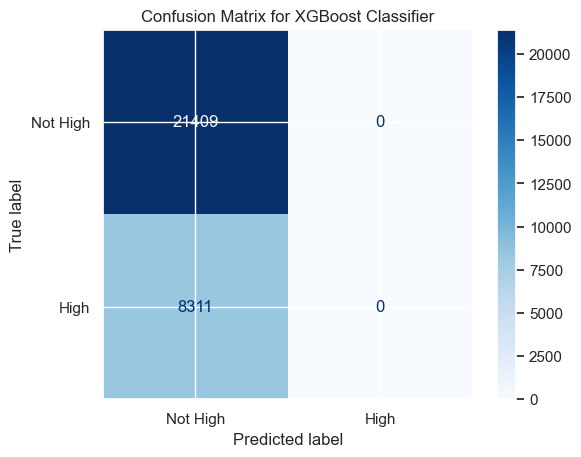

In [ ]:

if mode_redo:
    # n 100 : 14.875
    xgb_mdl = xgb.XGBClassifier(
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=halving_search_3.best_params_["max_depth"],
        learning_rate=halving_search_3.best_params_["learning_rate"],
        subsample=halving_search_3.best_params_["subsample"],
        colsample_bytree=halving_search_3.best_params_["colsample_bytree"],
        reg_alpha=halving_search_3.best_params_["reg_alpha"],
        reg_lambda=halving_search_3.best_params_["reg_lambda"],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=10000,#400+59+1,
    )
    xgb_mdl.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=0,
    )
    print("Model trained.")
    # save xgb_mdl
    with open(os.path.join(path_data,'xgb_mdl_03.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl, f)
else:
    # load  xgb_mdl
    xgb_mdl = pickle.load(open(os.path.join(path_data,'xgb_mdl_03.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [ ]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train  gain_train  trades_test  precision_test  \
0              0.0              0.0        -0.0          0.0             0.0   
1              0.0              0.0        -0.0          0.0             0.0   
2              0.0              0.0        -0.0          0.0             0.0   
3              0.0              0.0        -0.0          0.0             0.0   
4              0.0              0.0        -0.0          0.0             0.0   
...            ...              ...         ...          ...             ...   
9995           0.0              0.0        -0.0          0.0             0.0   
9996           0.0              0.0        -0.0          0.0             0.0   
9997           0.0              0.0        -0.0          0.0             0.0   
9998           0.0              0.0        -0.0          0.0             0.0   
9999           0.0              0.0        -0.0          0.0             0.0   

      gain_test  run_index  
0          -0.0          0  
1          -0.0          1  
2          -0.0          2  
3          -0.0          3  
4          -0.0          4  
...         ...        ...  
9995       -0.0       9995  
9996       -0.0       9996  
9997       -0.0       9997  
9998       -0.0       9998  
9999       -0.0       9999  

[10000 rows x 7 columns]

In [ ]:
fun_plot_pre_trade(df)

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_46280/2347049489.py:5: RuntimeWarning:

divide by zero encountered in divide



In [ ]:
fun_plot_xgb_rounds(df)